In [ ]:
map_rand_to_range(rand_float, a, b) = (rand_float - a) / (b - a)

map_vehicles_to_slowing_factor(num_vehicles) = 1 - e ^ (-0.01num_vehicles)

function generate_weights_with_factors(edge_len, speed_limit;
                                        bad_weather=false, traffic_light=false,
                                        num_vehicles=0)
    # Units
    # edge_len: meters
    # speed_limit: m/s
    # Assume that bad_weather slows a vehicle by 30% - 50%;
    # Traffic light increases the edge weights by 10% - 30%;
    # so is number of vehicles on the edge;
    
    weight = edge_len / speed_limit
    
    traffic_light && (weight *= (1 + map_rand_to_range(rand(), 0.1, 0.3)))
    
    bad_weather && (weight *= (1 + map_rand_to_range(rand(), 0.3, 0.5)))
    
    weight *= (1 + map_vehicles_to_slowing_factor(num_vehicles))
    
    return weight
end

In [ ]:
Pkg.add("PyPlot");

In [1]:
using GraphPlot
using LightGraphs
using PyPlot
using LightGraphs
import LightGraphs.SimpleGraphs: SimpleEdge, SimpleDiGraph
include("CreateOSMGraphs.jl")
using CreateOSMGraphs

INFO: Precompiling module PyPlot.

Use "const Styles = @compat Union{Style,Dict{Int,Style}}" instead.


In [3]:
using PyCall

In [4]:
@pyimport networkx as nx

In [5]:
@time graph, vprops, eprops, edgeDict, 
nodesLLA, highways, geohash2edgedict = CreateOSMGraphs.CreateOSMGraph("kista.osm");

getOSMData
  1.173239 seconds (8.83 M allocations: 400.205 MiB, 10.13% gc time)
intersections
  0.000291 seconds (1.51 k allocations: 186.500 KiB)
roadways
  0.010340 seconds (1.98 k allocations: 129.298 KiB)
segmentHighways
  0.238950 seconds (93.10 k allocations: 4.759 MiB, 2.73% gc time)
createGraph
  0.171596 seconds (137.22 k allocations: 5.745 MiB)
  3.061470 seconds (9.85 M allocations: 452.959 MiB, 4.69% gc time)


In [6]:
function build_networkx_graph(julia_graph)
    G = nx.DiGraph()
    
    for (edge, _) in edgeDict
#         print(node, coord[0], coord[1])
        nx.add_path(G, [edge.src, edge.dst])
    
    end
    
    G
end

function build_ground_truth_path(path_edges)
    
    path = [path_edges[1].src]
    
    for edge in path_edges
       push!(path, edge.dst) 
    end
    
    return path
end

build_networkx_graph (generic function with 1 method)

In [74]:
locs_x = Array{Float64, 1}(nv(graph))
locs_y = Array{Float64, 1}(nv(graph))

for (k, v) in sort(vprops, by=x -> vprops[x])
    println(nodesLLA[k].coords.lat, ",", nodesLLA[k].coords.lon)
    locs_x[v] = nodesLLA[k].coords.lon
    locs_y[v] = nodesLLA[k].coords.lat
end

59.4048649,17.9408975
59.4057929,17.942022
59.4021367,17.9709812
59.4023485,17.9523533
59.4064887,17.9450009
59.4090091,17.9747309
59.4035925,17.9538342
59.4046285,17.9477561
59.4067087,17.939507
59.4048035,17.9428344
59.4049581,17.9426232
59.40217,17.9467437
59.4061973,17.952379
59.4029988,17.949933
59.4091545,17.957725
59.4016303,17.9452049
59.4075072,17.9429575
59.4014547,17.9712111
59.4029809,17.9546129
59.4050599,17.9428575
59.40213,17.9711586
59.4074026,17.9378328
59.399151,17.9574592
59.3970601,17.953012
59.4038729,17.945633
59.4026809,17.973279
59.4070218,17.9447831
59.4022743,17.9524516
59.4079813,17.9586985
59.4126461,17.9328149
59.4055248,17.9424466
59.4022958,17.9633678
59.407488,17.9376889
59.3940158,17.949713
59.4081635,17.9600539
59.4024022,17.9480158
59.3965991,17.9524781
59.4020528,17.9701578
59.4064687,17.9360131
59.396298,17.9511611
59.4028937,17.9435934
59.3989595,17.9567369
59.4047155,17.9673637
59.4004262,17.9623219
59.4012038,17.958726
59.3997222,17.9495196
59.40

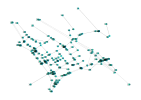

In [68]:
gplot(graph, locs_x, -locs_y, 
            arrowlengthfrac=0.0,
            nodelabel=1:nv(graph),
            NODELABELSIZE=2)

In [64]:
gt_path_nodes

14-element Array{Int64,1}:
  55
 181
 116
  66
  71
 161
 133
 210
  95
 141
 111
 142
  89
 186

In [108]:
G = build_networkx_graph(graph)

PyObject <networkx.classes.digraph.DiGraph object at 0x7fd144f2a7d0>

In [109]:
pos = Dict()

for (edge, _) in edgeDict
    pos[edge.src] = (locs_x[edge.src], locs_y[edge.src])
    pos[edge.dst] = (locs_x[edge.dst], locs_y[edge.dst])
end

node_color = ["c" for _ in 1:nv(graph)];
node_size = [5 for _ in 1:nv(graph)];

In [110]:
gt_path_edges = a_star(graph, 25, 75)
gt_path_nodes = build_ground_truth_path(gt_path_edges)

nn_path_nodes = [55, 93, 82, 47, 164, 126, 118, 46, 141, 111, 142, 89, 186];

In [111]:
# Mark ground truth path
node_color[gt_path_nodes[end]] = "g"
node_color[gt_path_nodes[1]] = "k"
node_size[gt_path_nodes[1]] = 50
node_size[gt_path_nodes[end]] = 50

for node in gt_path_nodes[2:end-1]
     node_color[node] = "r"
end

# Mark nn path
# for node in nn_path_nodes[2:end-1]
#      node_color[node] = "b"
# end

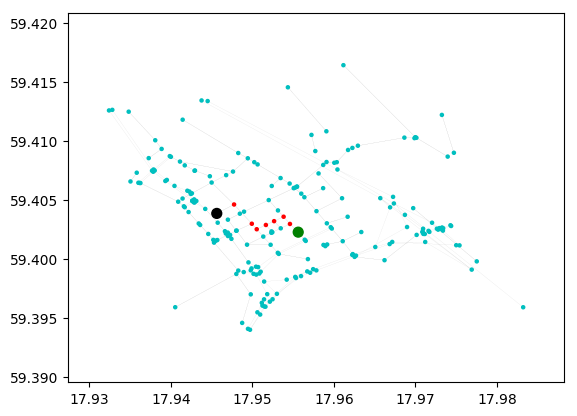

In [112]:
nx.draw_networkx(G, pos=pos, 
                    with_labels=false,
#                     nodelist=1:nv(graph),
                    node_size=node_size, 
                    width=0.02,
                    arrows=false,
                    node_color=node_color)

In [102]:
println(locs_x[gt_path_nodes[1]], ",", locs_y[gt_path_nodes[1]])
println(locs_x[gt_path_nodes[end]], ",", locs_y[gt_path_nodes[end]])

17.9405351,59.3959262
17.9578672,59.4040631
